# Tatoeba: Exploratory data analysis (EDA) and Dataset partitioning

Authors: Pierre Nugues and Marcus Klang

Tatoeba is a collection of sentences in many languages. They can be sentences in one language, for instance French, or translations, i.e. resulting in pairs of sentences in two languages, for instance French and English.

Tatoeba is a collaborative site and anyone can contribute and download the dataset here: https://tatoeba.org/downloads. As all the sentences are annotated with their language, many applications use Tatoeba to train machine-learning models. This includes translation and language detection.

Over the time, Tatoeba has become quite large. In this notebook, we will carry out a small exploratory data analysis of its content and see how we can extract a part of it.

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [1]:
import os
import random
from collections import Counter
import tarfile
import torch
import matplotlib.pyplot as plt

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Downloading the Dataset

Remove the comments the first time you run this notebook

In [3]:
!wget https://downloads.tatoeba.org/exports/sentences.tar.bz2

--2025-11-26 13:49:22--  https://downloads.tatoeba.org/exports/sentences.tar.bz2
Resolving downloads.tatoeba.org (downloads.tatoeba.org)... 94.130.77.194
Connecting to downloads.tatoeba.org (downloads.tatoeba.org)|94.130.77.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210282893 (201M) [application/octet-stream]
Saving to: ‘sentences.tar.bz2’

sentences.tar.bz2   100%[===================>] 200.54M  28.6MB/s    in 6.9s    

2025-11-26 13:49:29 (29.1 MB/s) - ‘sentences.tar.bz2’ saved [210282893/210282893]



In [10]:
tarfile.open('sentences.tar.bz2').extractall(filter='data')

In [11]:
TATOEBA_FILE = 'sentences.csv'

In [12]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'
SENT_PER_LANG_SMALL = 1000
SENT_PER_LANG_LARGE = 15000
MIN_SENT_PER_LANG = 20000

In [13]:
SMALL = False

In [14]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
    sent_per_lang = SENT_PER_LANG_SMALL

else:
    dataset_path = LARGE_DATASET_PATH
    sent_per_lang = SENT_PER_LANG_LARGE

## Content of the file

We read the first lines of the file. It has a tabulated structure.
   * The separator is a tabulation (\t)
   * Three columns
       + Unique id, number
       + Language code (ISO 639-3)
       + Sentence encoded using unicode (UTF-8)

In [15]:
with open(TATOEBA_FILE, encoding='utf8', errors='ignore') as f:
    for cnt, line in enumerate(f):
        if cnt >= 10:
            break
        row = line.strip()
        print(tuple(row.split('\t')))

('1', 'cmn', '我們試試看！')
('2', 'cmn', '我该去睡觉了。')
('3', 'cmn', '你在干什麼啊？')
('4', 'cmn', '這是什麼啊？')
('5', 'cmn', '今天是６月１８号，也是Muiriel的生日！')
('6', 'cmn', '生日快乐，Muiriel！')
('7', 'cmn', 'Muiriel现在20岁了。')
('8', 'cmn', '密码是"Muiriel"。')
('9', 'cmn', '我很快就會回來。')
('10', 'cmn', '我不知道。')


## Reading the complete file and counting the lines

We create a generator

In [16]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [17]:
line_generator = file_reader(TATOEBA_FILE)

We count the lines. Note that this can take time.

In [19]:
cnt = 0
for _ in line_generator:
    cnt += 1
cnt

0

Nonetheless, a small dataset by today's standards.

We need to recreate `line_generator()` each time we run it.

In [20]:
cnt = 0
for _ in line_generator:
    cnt += 1
cnt

0

## Counting the Sentences per Language

For this, we recreate our generator

In [21]:
line_generator = file_reader(TATOEBA_FILE)

And we count the sentences per language

In [22]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [23]:
lang_freqs.most_common(15)

[('eng', 2002670),
 ('rus', 1168945),
 ('ita', 949191),
 ('epo', 803010),
 ('kab', 776647),
 ('tur', 743196),
 ('deu', 742939),
 ('fra', 696613),
 ('ber', 693674),
 ('por', 438628),
 ('spa', 426126),
 ('hun', 425701),
 ('jpn', 248017),
 ('heb', 210482),
 ('nld', 194881)]

We plot them

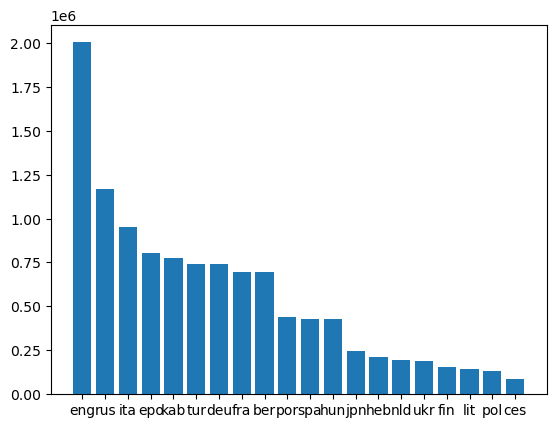

In [24]:
lang, cnt = zip(*lang_freqs.most_common(20))
x_pos = torch.arange(len(lang))
plt.bar(x_pos, cnt)
plt.xticks(x_pos, lang)
plt.show()

## Selecting the Languages
We consider languages with many examples, more than a fixed threshold

In [25]:
selected_langs = {lang: freq for lang,
                  freq in lang_freqs.items() if freq > MIN_SENT_PER_LANG}

In [26]:
len(selected_langs), selected_langs

(50,
 {'cmn': 82628,
  'deu': 742939,
  'rus': 1168945,
  'fra': 696613,
  'eng': 2002670,
  'jpn': 248017,
  'spa': 426126,
  'ita': 949191,
  'vie': 28982,
  'nld': 194881,
  'epo': 803010,
  'por': 438628,
  'tur': 743196,
  'heb': 210482,
  'hun': 425701,
  'ell': 40971,
  'ind': 26291,
  'ara': 67148,
  'fin': 152815,
  'bul': 25452,
  'yue': 20109,
  'swe': 56332,
  'ukr': 187798,
  'ces': 85280,
  'pol': 134102,
  'lat': 53457,
  'ron': 37779,
  'tat': 66417,
  'yid': 25983,
  'srp': 51413,
  'dan': 66028,
  'pes': 31588,
  'slk': 28944,
  'tgl': 76789,
  'hye': 45588,
  'lit': 141826,
  'mkd': 78254,
  'tok': 70456,
  'ina': 40576,
  'tlh': 36500,
  'oci': 23683,
  'kab': 776647,
  'ber': 693674,
  'mar': 80319,
  'hau': 21823,
  'lfn': 37089,
  'zgh': 20655,
  'tig': 51125,
  'shi': 22666,
  'swc': 23821})

## Selection of Sentences

To ease training, we select `sent_per_lang` sentences (15,000 or 1000) of each language in `selected_languages`. For this, we first write a generator that will return the sentence if it is less than a random number. We use a uniform random generator between 0 and 1. If we want to select 10% of the sentences of a given language, we will return the sentence when the random number is less than 0.1, for 20%, it will be 0.2, etc.

The percentage is given by `sent_per_lang` divided by the number of sentence in the language.

We first write a generator that will return the sentence if it is less than a random number. We use a uniform random generator between 0 and 1. If we want to select 10% of the sentences of a given language, we will return the sentence when the random number is less than 0.1, for 20%, it will be 0.2, etc.

In [27]:
lang_percentage = dict()
for lang, freq in selected_langs.items():
    lang_percentage[lang] = sent_per_lang/freq

In [28]:
lang_percentage

{'cmn': 0.18153652514885996,
 'deu': 0.02019008290048039,
 'rus': 0.012832083630966384,
 'fra': 0.021532759222121896,
 'eng': 0.007490000848866763,
 'jpn': 0.060479725180128785,
 'spa': 0.03520085608481998,
 'ita': 0.015802931127665558,
 'vie': 0.5175626250776344,
 'nld': 0.07697004838850376,
 'epo': 0.018679717562670454,
 'por': 0.03419754324849303,
 'tur': 0.020183101093116756,
 'heb': 0.07126500128277002,
 'hun': 0.03523599897580696,
 'ell': 0.36611261624075564,
 'ind': 0.5705374462743905,
 'ara': 0.22338714481443975,
 'fin': 0.09815790334718451,
 'bul': 0.5893446487505893,
 'yue': 0.7459346561241236,
 'swe': 0.26627849179862245,
 'ukr': 0.07987305509110854,
 'ces': 0.17589118198874296,
 'pol': 0.11185515503124488,
 'lat': 0.28059936023345866,
 'ron': 0.3970459779242436,
 'tat': 0.22584579249288586,
 'yid': 0.5773005426625101,
 'srp': 0.2917550035983117,
 'dan': 0.2271763494275156,
 'pes': 0.4748638723565911,
 'slk': 0.5182421227197347,
 'tgl': 0.19534047845394523,
 'hye': 0.3290339

In [29]:
def sentence_selector(file, lang_percentage):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in lang_percentage and torch.rand(1).item() < lang_percentage[lang]:
                yield lang_tuple

In [30]:
working_corpus = sentence_selector(TATOEBA_FILE, lang_percentage)

We create an in-memory list of the generator to enable later shuffling

In [31]:
working_corpus = list(working_corpus)
print('line count:', len(working_corpus))
working_corpus[:3]

line count: 749843


[('1', 'cmn', '我們試試看！'), ('4', 'cmn', '這是什麼啊？'), ('12', 'cmn', '這個永遠完不了了。')]

Much smaller and balanced

In [32]:
Counter(map(lambda x: x[1], working_corpus))

Counter({'deu': 15232,
         'lat': 15208,
         'por': 15194,
         'eng': 15163,
         'slk': 15126,
         'lit': 15121,
         'hun': 15120,
         'shi': 15117,
         'mar': 15089,
         'ita': 15087,
         'fin': 15082,
         'pol': 15070,
         'pes': 15067,
         'cmn': 15059,
         'vie': 15046,
         'ces': 15041,
         'bul': 15029,
         'ukr': 15020,
         'ind': 15019,
         'hye': 15019,
         'ron': 15015,
         'mkd': 15014,
         'yue': 15008,
         'ell': 15004,
         'zgh': 15002,
         'swc': 14999,
         'oci': 14994,
         'tat': 14991,
         'ina': 14986,
         'yid': 14979,
         'epo': 14974,
         'spa': 14971,
         'fra': 14969,
         'nld': 14967,
         'swe': 14961,
         'tgl': 14949,
         'tok': 14943,
         'srp': 14936,
         'lfn': 14934,
         'tlh': 14916,
         'tig': 14912,
         'ber': 14881,
         'rus': 14875,
         'h

## Splitting the corpus
We split the corpus in three subsets: 
* training set
* validation set (also called development set)
* test set

In [33]:
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.1
TEST_PERCENT = 0.1

In [34]:
random.shuffle(working_corpus)

In [35]:
split_sizes = list(map(lambda x: int(len(working_corpus) * x),
                   (TRAIN_PERCENT, VAL_PERCENT, TEST_PERCENT)))
split_sizes

[599874, 74984, 74984]

In [36]:
split_idx = [split_sizes[0], split_sizes[0] + split_sizes[1]]
split_idx

[599874, 674858]

Finally, we store the files

In [37]:
def dump_split_dataset(dataset_path, dataset, indices):
    # We assume a train, validation, and test sets
    os.makedirs(dataset_path, exist_ok=True)
    train_out = open(os.path.join(dataset_path, 'train.tsv'), mode='w')
    val_out = open(os.path.join(dataset_path, 'val.tsv'), mode='w')
    test_out = open(os.path.join(dataset_path, 'test.tsv'), mode='w')
    for i in range(len(dataset)):
        line = '{}\t{}\t{}\n'.format(
            dataset[i][0], dataset[i][1], dataset[i][2])
        if i < indices[0]:
            train_out.write(line)
        elif i < indices[1]:
            val_out.write(line)
        else:
            test_out.write(line)
    train_out.close()
    val_out.close()
    test_out.close()

In [38]:
dump_split_dataset(dataset_path, working_corpus, split_idx)